## Training

In [1]:
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense, Input, Add, merge, concatenate
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras import metrics
from keras import optimizers
from keras.utils import plot_model
from keras import backend as K
from keras.utils.training_utils import multi_gpu_model
from keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.initializers import he_uniform
from keras.initializers import glorot_uniform

import numpy as np
import sys
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("models/")
sys.path.append("scripts/")

/usr/local/anaconda3/envs/deeplearning/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from my_classes import DataGenerator, AugmentedDataGenerator

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4, 5, 6, 7"

In [4]:
# Load the data
h5f = h5py.File('data/data_cano_distributed2.h5', 'r')
train_x, train_y = h5f['train_x'][:], h5f['train_y'][:]
valid_x, valid_y = h5f['valid_x'][:], h5f['valid_y'][:]
test_x, test_y = h5f['test_x'][:], h5f['test_y'][:]
h5f.close()

print(train_x.shape, valid_x.shape, test_x.shape)

(3011, 24, 24, 24, 16) (377, 24, 24, 24, 16) (376, 24, 24, 24, 16)


In [5]:
from models import Squeeze_model

In [6]:
# from IPython.display import SVG
# from keras.utils.vis_utils import plot_model, model_to_dot
# model_input = Input(shape=(24, 24, 24, 16))
# squeeze_model = Model(inputs=model_input, outputs=Squeeze_model(model_input))
# #plot_model(squeeze_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# SVG(model_to_dot(squeeze_model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
# # plot_model(get_model4((24, 24, 24, 16)))

In [7]:
# Training parameters
nb_gpus = 4
nb_batch = nb_gpus*16
nb_epochs = 200
l_rate = 1e-5
decay_rate = l_rate / nb_epochs

In [8]:
# checkpoint
outputFolder = './weights'
# if not os.path.exists(outputFolder):
#     os.makedirs(outputFolder)

filepath=outputFolder+"/weights-distributed_cano_original.h5"

callbacks_list = [ModelCheckpoint(filepath, 
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=True,
                                  mode='auto', period=1)]

In [9]:
data_gen = DataGenerator(x=train_x, y=train_y, batch_size=nb_batch)
val_gen = DataGenerator(x=valid_x, y=valid_y, batch_size=nb_batch)

In [10]:
# Build the model and train
model_input = Input(shape=(24, 24, 24, 16))
squeeze_model = Model(inputs=model_input, outputs=Squeeze_model(model_input))
model = multi_gpu_model(squeeze_model, gpus=nb_gpus)
decay_rate = l_rate / nb_epochs
model.compile(optimizer=optimizers.adam(lr=l_rate),# decay=decay_rate, beta_1=0.99, beta_2=0.999),
              loss='mean_absolute_error')
              #target_tensors=[staging_area_callback.target_tensor],
              #fetches=staging_area_callback.extra_ops)

In [11]:
history = model.fit_generator(generator=data_gen, validation_data=val_gen,
                              use_multiprocessing=False, 
                              epochs=nb_epochs, 
                              max_queue_size=10, 
                              workers=56, 
                              verbose=1, callbacks=callbacks_list)

Epoch 1/200
47/47 [==============================] - 12s 251ms/step - loss: 6.3491 - val_loss: 6.2814

Epoch 00001: val_loss improved from inf to 6.28138, saving model to ./weights/weights-distributed_cano_original.h5
Epoch 2/200
47/47 [==============================] - 5s 111ms/step - loss: 2.9974 - val_loss: 1.5683

Epoch 00002: val_loss improved from 6.28138 to 1.56826, saving model to ./weights/weights-distributed_cano_original.h5
Epoch 3/200
47/47 [==============================] - 5s 115ms/step - loss: 1.5920 - val_loss: 1.6035

Epoch 00003: val_loss did not improve
Epoch 4/200
47/47 [==============================] - 5s 111ms/step - loss: 1.5615 - val_loss: 1.4666

Epoch 00004: val_loss improved from 1.56826 to 1.46655, saving model to ./weights/weights-distributed_cano_original.h5
Epoch 5/200
47/47 [==============================] - 5s 112ms/step - loss: 1.5639 - val_loss: 1.4574

Epoch 00005: val_loss improved from 1.46655 to 1.45736, saving model to ./weights/weights-distribu

47/47 [==============================] - 7s 144ms/step - loss: 1.4095 - val_loss: 1.2945

Epoch 00055: val_loss improved from 1.31997 to 1.29449, saving model to ./weights/weights-distributed_cano_original.h5
Epoch 56/200
47/47 [==============================] - 7s 139ms/step - loss: 1.4182 - val_loss: 1.4867

Epoch 00056: val_loss did not improve
Epoch 57/200
47/47 [==============================] - 7s 140ms/step - loss: 1.3748 - val_loss: 1.3790

Epoch 00057: val_loss did not improve
Epoch 58/200
47/47 [==============================] - 6s 136ms/step - loss: 1.4355 - val_loss: 1.3890

Epoch 00058: val_loss did not improve
Epoch 59/200
47/47 [==============================] - 6s 138ms/step - loss: 1.4379 - val_loss: 1.3804

Epoch 00059: val_loss did not improve
Epoch 60/200
47/47 [==============================] - 7s 141ms/step - loss: 1.4207 - val_loss: 1.4783

Epoch 00060: val_loss did not improve
Epoch 61/200
47/47 [==============================] - 7s 138ms/step - loss: 1.4460 - v

47/47 [==============================] - 6s 136ms/step - loss: 1.0980 - val_loss: 1.4653

Epoch 00112: val_loss did not improve
Epoch 113/200
47/47 [==============================] - 6s 137ms/step - loss: 1.0980 - val_loss: 1.4688

Epoch 00113: val_loss did not improve
Epoch 114/200
47/47 [==============================] - 6s 134ms/step - loss: 1.0880 - val_loss: 1.4465

Epoch 00114: val_loss did not improve
Epoch 115/200
47/47 [==============================] - 6s 135ms/step - loss: 1.0716 - val_loss: 1.4422

Epoch 00115: val_loss did not improve
Epoch 116/200
47/47 [==============================] - 7s 139ms/step - loss: 1.0663 - val_loss: 1.4418

Epoch 00116: val_loss did not improve
Epoch 117/200
47/47 [==============================] - 7s 138ms/step - loss: 1.0866 - val_loss: 1.6965

Epoch 00117: val_loss did not improve
Epoch 118/200
47/47 [==============================] - 6s 135ms/step - loss: 1.0462 - val_loss: 1.4142

Epoch 00118: val_loss did not improve
Epoch 119/200
47/47 

47/47 [==============================] - 7s 138ms/step - loss: 0.5474 - val_loss: 1.6238

Epoch 00170: val_loss did not improve
Epoch 171/200
47/47 [==============================] - 6s 134ms/step - loss: 0.5343 - val_loss: 1.6249

Epoch 00171: val_loss did not improve
Epoch 172/200
47/47 [==============================] - 6s 137ms/step - loss: 0.5942 - val_loss: 1.6393

Epoch 00172: val_loss did not improve
Epoch 173/200
47/47 [==============================] - 7s 138ms/step - loss: 0.4957 - val_loss: 1.6114

Epoch 00173: val_loss did not improve
Epoch 174/200
47/47 [==============================] - 9s 201ms/step - loss: 0.4685 - val_loss: 1.5098

Epoch 00174: val_loss did not improve
Epoch 175/200
47/47 [==============================] - 17s 366ms/step - loss: 0.4256 - val_loss: 1.5940

Epoch 00175: val_loss did not improve
Epoch 176/200
47/47 [==============================] - 14s 297ms/step - loss: 0.4772 - val_loss: 1.6370

Epoch 00176: val_loss did not improve
Epoch 177/200
47/4

In [12]:
# Save the history
import pickle

with open(os.path.join(outputFolder, "history_distributed_cano_original.pickle"), 'wb') as f:
    pickle.dump(history.history, f)

In [13]:
# Save the weights
model.load_weights(filepath)

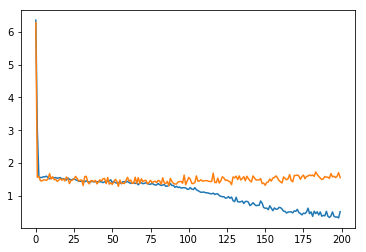

In [14]:
# First 100 epochs
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [15]:
from sklearn.metrics import r2_score

In [16]:
#train_r2 = r2_score(y_true=train_y, y_pred=model.predict(train_x))
train_r2 = r2_score(y_true=train_y[:2000], y_pred=model.predict(train_x[:2000]))
print("Train r2: ", train_r2)

Train r2:  0.2468284313074307


In [17]:
#train_r2 = r2_score(y_true=train_y, y_pred=model.predict(train_x))
test_r2 = r2_score(y_true=test_y, y_pred=model.predict(test_x))
print("Test r2: ", test_r2)

Test r2:  0.2143474265995181
